In [1]:
import os
os.chdir("../../..")
import deepof.data

In [2]:
%load_ext autoreload
%autoreload 2

# Formatting your data: feature extraction from motion tracking output

In [3]:
# Create and run a project. Explore different processing parameters (smoothing, imputation)

In [4]:
my_deepof_project = deepof.data.Project(
                path=os.path.join("../../Desktop/deepOF_CSDS_tutorial_dataset/"),
                arena="circular-autodetect",
                animal_ids=["B", "W"],
                video_format=".mp4",
                exclude_bodyparts=["Tail_1", "Tail_2", "Tail_tip"],
                video_scale=380,
                enable_iterative_imputation=False,
                exp_conditions={
                    '20191204_Day2_SI_JB08_Test_56': 'Stressed',
                    '20191204_Day2_SI_JB08_Test_61': 'Stressed',
                    '20191204_Day2_SI_JB08_Test_62': 'Stressed',
                    '20191204_Day2_SI_JB08_Test_54': 'Nonstressed',
                    '20191204_Day2_SI_JB08_Test_63': 'Nonstressed',
                    '20191204_Day2_SI_JB08_Test_64': 'Nonstressed'
                }
)

In [6]:
# my_deepof_project = my_deepof_project.run()

In [7]:
# Save your project to avoid laborious repetitions

In [8]:
# my_deepof_project.save("../../Desktop/deepOF_CSDS_tutorial_dataset/deepof_tutorial_saved_coordinates")

In [9]:
# Load a previously saved project
my_deepof_project = deepof.data.load("../../Desktop/deepOF_CSDS_tutorial_dataset/deepof_tutorial_saved_coordinates_1671770469.pkl")

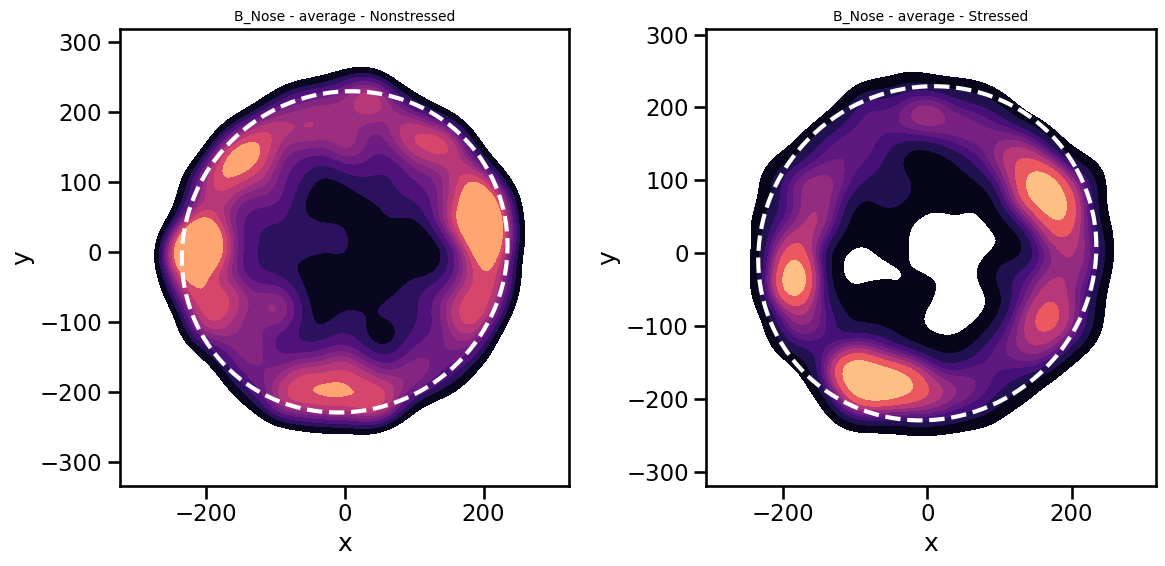

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import deepof.visuals
from matplotlib.patches import Ellipse

sns.set_context("talk")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

deepof.visuals.plot_heatmaps(
    my_deepof_project, 
    ["B_Nose"],
    center="arena", 
    exp_condition="Nonstressed",
    ax=ax1,
    show=False,
    display_arena=True,
    experiment_id="average",
)

deepof.visuals.plot_heatmaps(
    my_deepof_project, 
    ["B_Nose"],
    center="arena", 
    exp_condition="Stressed",
    ax=ax2,
    show=False,
    display_arena=True,
    experiment_id="average",
)

plt.tight_layout()
plt.show()

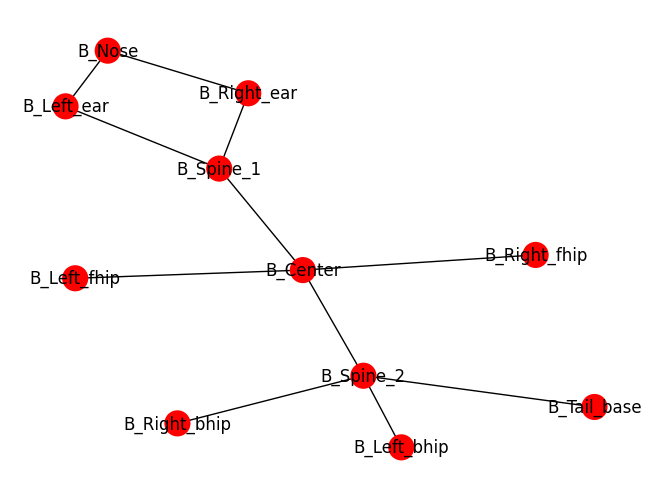

In [11]:
import networkx as nx
from deepof.utils import connect_mouse_topview

G = connect_mouse_topview(animal_ids=["B"], exclude_bodyparts=["Tail_1", "Tail_2", "Tail_tip"])

# Include a (nicer) version of this plot in the tutorial
nx.draw(G, 
        with_labels=True, 
        pos=nx.spring_layout(G), 
        node_color=["red" if i.startswith("B") else "blue" for i in G.nodes()])

In [12]:
# Create a preprocessed version of the dataset we're after
pp = my_deepof_project.get_graph_dataset(animal_id="B", center="Center", align="Spine_1", preprocess=True)

/Users/lucas_miranda/Library/Caches/pypoetry/virtualenvs/deepof-qxwF8hwh-py3.9/lib/python3.9/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)


In [17]:
pp[1].shape

(89968, 25, 11, 11)

In [ ]:
%%time
cons = my_deepof_project.deep_unsupervised_embedding(
    pp,
    embedding_model="VQVAE",
    epochs=1,
    encoder_type="recurrent",
    n_components=15,
    latent_dim=8,
    kl_warmup=10,
    kl_annealing_mode="linear",
    batch_size=128,
    kmeans_loss=0.0,
    reg_cat_clusters=0.0,
)

2022-12-23 07:14:51.714564: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-12-23 07:14:51.714579: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-12-23 07:14:51.714645: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-12-23 07:15:03.760530: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


  1/702 [..............................] - ETA: 6:25:54 - total_loss: 112.9272 - encoding_reconstruction_loss: 55.8206 - reconstruction_loss: 55.0887 - vq_loss: 1.4827 - number_of_populated_clusters: 8.0000

2022-12-23 07:15:37.288698: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-12-23 07:15:37.288720: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-12-23 07:15:44.935548: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-23 07:15:45.002696: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-12-23 07:15:45.070447: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /Users/lucas_miranda/PycharmProjects/deepof/unsupervised_trained_models/fit/deepof_unsupervised_VQVAE_recurrent_encodings_input_type=coords_kmeans_loss=0.0_encoding=8_k=15_20221223-071451/plugins/profile/2022_12_23_07_15_45



  2/702 [..............................] - ETA: 1:32:34 - total_loss: 120.7785 - encoding_reconstruction_loss: 59.4955 - reconstruction_loss: 58.9951 - vq_loss: 2.1743 - number_of_populated_clusters: 7.0000

2022-12-23 07:15:45.157358: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /Users/lucas_miranda/PycharmProjects/deepof/unsupervised_trained_models/fit/deepof_unsupervised_VQVAE_recurrent_encodings_input_type=coords_kmeans_loss=0.0_encoding=8_k=15_20221223-071451/plugins/profile/2022_12_23_07_15_45/MC-C9791E.local.trace.json.gz
2022-12-23 07:15:45.210855: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /Users/lucas_miranda/PycharmProjects/deepof/unsupervised_trained_models/fit/deepof_unsupervised_VQVAE_recurrent_encodings_input_type=coords_kmeans_loss=0.0_encoding=8_k=15_20221223-071451/plugins/profile/2022_12_23_07_15_45

2022-12-23 07:15:45.211073: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to /Users/lucas_miranda/PycharmProjects/deepof/unsupervised_trained_models/fit/deepof_unsupervised_VQVAE_recurrent_encodings_input_type=coords

164/702 [======>.......................] - ETA: 1:32 - total_loss: 102.8811 - encoding_reconstruction_loss: 51.0829 - reconstruction_loss: 50.3960 - vq_loss: 1.3252 - number_of_populated_clusters: 3.8415

In [ ]:
# Do cluster assignments differ significantly across animals? Can we detect the animal from the assignments' histogram?
# Leave for later, when implementing the cluster enrichment and viz functions

In [ ]:
from IPython import display

video = deepof.visuals.animate_skeleton(
    my_deepof_project,
    #embedding=emb,
    #cluster_assignments=clust_ass,
    #animal_id="W",
    experiment_id="20191204_Day2_SI_JB08_Test_54",
    frame_limit=250,
    # selected_cluster=0,
    dpi=60,
    # center="Center",
    # align="Spine_1",
    #embedding=[emb_B, emb_W],
    save="SAB_multi_animal_example.mp4",
)

html = display.HTML(video)
display.display(html)
plt.close()

In [ ]:
# Single animal display

In [ ]:
from sklearn.decomposition import PCA

emb = PCA(n_components=3).fit_transform(my_deepof_project.get_coords().filter_id("B")['20191204_Day2_SI_JB08_Test_56'])

In [ ]:
from IPython import display

video = deepof.visuals.animate_skeleton(
    my_deepof_project,
    animal_id="B",
    embedding=emb,
    experiment_id="20191204_Day2_SI_JB08_Test_56",
    frame_limit=750,
    dpi=60,
)

html = display.HTML(video)
display.display(html)
plt.close()

In [ ]:
emb = PCA(n_components=3).fit_transform(my_deepof_project.get_coords(center="Center", align="Spine_1").filter_id("B")['20191204_Day2_SI_JB08_Test_56'])

In [ ]:
from IPython import display

video = deepof.visuals.animate_skeleton(
    my_deepof_project,
    center="Center",
    align="Spine_1",
    animal_id="B",
    embedding=emb,
    experiment_id="20191204_Day2_SI_JB08_Test_56",
    frame_limit=750,
    dpi=60,
)

html = display.HTML(video)
display.display(html)
plt.close()

In [ ]:
# Get and plot coordinates, distances, angles, and areas. Try and visualizing different centering and rotations

In [ ]:
my_deepof_project.get_coords(polar=True)['20191204_Day2_SI_JB08_Test_54']

In [ ]:
my_deepof_project.get_distances()['20191204_Day2_SI_JB08_Test_54']

In [ ]:
my_deepof_project.get_angles()['20191204_Day2_SI_JB08_Test_54']

In [ ]:
my_deepof_project.get_areas()

In [ ]:
my_deepof_project.get_areas()['20191204_Day2_SI_JB08_Test_54']

In [ ]:
# Show how to merge different feature objects

my_deepof_project.get_coords().pca()